# Direct Detection - Simulating and Analyzing Data
### Adam Wise - 3/29/19

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The idea here is to simulate some expected data for a direct detection experiment.

What needs to be included in simulated data?  First, at least the readout noise of the sensor.  This will be the limiting factor in energy resolution, but in our case will be quite low.  The way I'll add the readout noise will be to create a background drawn from a Poisson distribution.  

To simulate capture high-energy photons, I'll create a dictionary with peak energies and intensities, and assume - for the moment - flat illumination of the sensor.  For each peak, I'll draw again from the Poisson distribution, with the mean set to the intensity of the peak times some exposure time, and scale the result by the number of photoelectrons we expect to create for each captured photon.  In this case, ~3.65 per eV of photon energy.

In [7]:
# define a dictionary of camera / sensor proprties
# includes sensor size in pixels, readout noise in electrons, dark current in electrons / pixel / sec.
camera_props = {
    'image_dimensions' : (256,256),
    'readout_noise' : 2.9,
    'dark_current' : 0.0001
}

# define a spectrum of peak energies, with the format energy (eV) : intensity (arb units)
spectrum = {
    5000 : 1,
    15000 : 0.4
}

# generate a simulated image, given a spectrum, dictionary of camera properties, and an exposure time
def generate_frame(spectrum, camera_props, exposure_time):
    
    # create a numpy array with the appropriate readout noise
    output = np.random.poisson(lam = camera_props['readout_noise'],
                               size = camera_props['image_dimensions'])
    
    # for each energy in the spectrum, simulate poission arrival for a uniformly illuminated field
    for energy in spectrum.keys():
        photoelectrons = int(3.65 * energy) # number of photoelectrons per x-ray photon absorbed
        output += photoelectrons * np.random.poisson( lam = spectrum[energy] * exposure_time
                                    , size = camera_props['image_dimensions'] )
    
    return output
    

Here is the general case of simulating a single frame of exposure to the light source - I have the exposure time set low to ensure the chance of capturing two photons in the same pixel is low.  You can turn it up and see what happens - if it's too high, small peaks will begin to emerge in the spectra corresponding to twice the energy of a real peak.

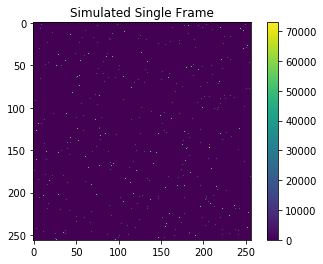

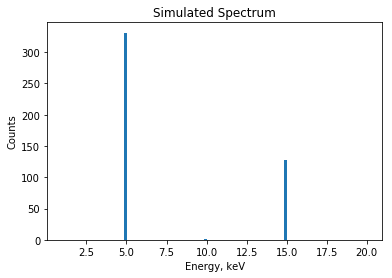

In [20]:
# generate a single frame of simulated data, show the expected image
# and then show a histogram of the data - when multiplied through by energy / photoelectron, this
# gives the spectrum 

exposure_time = 0.005 # pick an exposure time for the simulated data

sim_data = generate_frame( spectrum, camera_props, exposure_time)

plt.figure()
plt.imshow(sim_data)
plt.title('Simulated Single Frame')
plt.colorbar()

energy_histogram = (sim_data / (3.65 * 1000)).ravel() # convert photoelectrons -> photon energy in keV

plt.figure()
plt.hist(energy_histogram , bins = np.linspace(1,20,100))
plt.title('Simulated Spectrum')
plt.xlabel('Energy, keV')
plt.ylabel('Counts')
plt.show()

To get a reasonable amount of counts to work with, multiple frames can be captured and combined.  The spectrum is easy to extract - against it's just the histogram of the data in all the frames pooled together, with a scaling factor to go from photoelectrons to photon energy.

To extract specific energy channels, I apply a filtering function to the stack of frames and then sum along the frame axis, summing the counts from a specific peak into one image.  Here it is not very interesting because the illumination is flat, but we can tweak this to show some spatial structure.

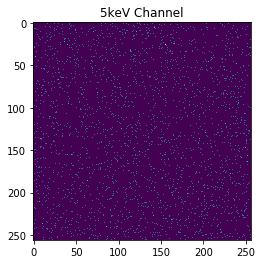

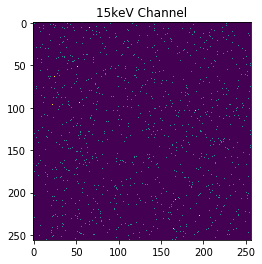

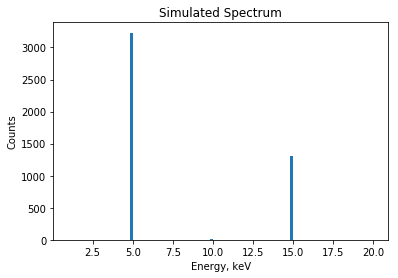

In [62]:
# generate a number of frames - this is what you'd get from Solis in one of these experiments
number_of_frames = 10;

# create an empty array of the appropriate size 
sim_data = np.zeros( camera_props['image_dimensions'] + (number_of_frames,) )

# simulate each frame and populate the empty array
for i in range(number_of_frames):
    sim_data[:,:,i] = generate_frame( spectrum, camera_props, exposure_time)
    
# define a filter function to pull out energy channels
def filter_function(value, target):
    if (value > target*0.9) & (value < target * 1.1):
        return 1
    else:
        return 0

# vectorize it for use on numpy arrays
vfilter = np.vectorize(filter_function)

# pull out the 5 keV channel:
data5kev = vfilter(sim_data, 5 * 1000 * 3.35).sum(axis=2)

# show the 5keV channel
plt.figure()
plt.imshow( data5kev)
plt.title('5keV Channel')

# pull out the 15 keV channel:
data15kev = vfilter(sim_data, 15 * 1000 * 3.65).sum(axis=2)

# show the 15keV channel
plt.figure()
plt.imshow( data15kev)
plt.title('15keV Channel')

energy_data = (sim_data / (3.65 * 1000)).ravel() # convert photoelectrons -> photon energy in keV

plt.figure()
plt.hist(energy_data , bins = np.linspace(1,20,100))
plt.title('Simulated Spectrum')
plt.xlabel('Energy, keV')
plt.ylabel('Counts')
plt.show()